In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Helper_Functions import Generate_Features, Quality_Evaluation
from skimage.io import imread
from skimage.transform import rescale
from sklearn.ensemble import RandomForestClassifier
from skimage.segmentation import random_walker
from multiprocessing import cpu_count
from skimage.morphology import opening, disk
import os
from sklearn.externals import joblib
from scipy.ndimage.morphology import binary_fill_holes


In [2]:
def RF_Post_Processed(Image,mask_Ego_Vehicle,mask_out_of_roi,thres1=0.9,thres2=0.5,sky_height=50,PP=True):
    nx,ny=Image.shape[0:2]
    Test_Features=np.reshape(Generate_Features(Image),[54,nx*ny]).T
    Prediction = RF.predict_proba(Test_Features)
    Prediction = Prediction.reshape([nx,ny,2])
    if PP==False:
        return Prediction[:,:,1]>0.5
    else:
        Non_Road_Seeds = Prediction[:,:,0]>thres1
        Sky=np.zeros(Prediction[:,:,0].shape, dtype=bool)
        Sky[0:sky_height,:]=True
        Non_Road_Seeds=(Non_Road_Seeds|Sky) 
        Non_Road_Seeds[mask_Ego_Vehicle]=False
        selem = disk(3)
        Non_Road_Seeds=opening(Non_Road_Seeds,selem)

        Road_Seeds=Prediction[:,:,1]>thres2
        Road_Seeds[0:110,:]=False
        Road_Seeds=Road_Seeds|mask_Ego_Vehicle
        selem = disk(7)
        Road_Seeds=opening(Road_Seeds,selem)
        labels=np.zeros(Prediction[:,:,0].shape, dtype=int)

        labels[Non_Road_Seeds]=1
        labels[Road_Seeds]=2

        Segmentation=random_walker(Image, labels, beta=250, multichannel=True)
        Result=np.zeros([nx,ny], dtype=bool)
        Result[Segmentation==2]=True
        Result=binary_fill_holes(Result)
        Result[mask_Ego_Vehicle]=False
        Result[mask_out_of_roi]=False
        return Result

In [3]:
def Get_Image_and_Ground_Truth(GT_path,Im_path):
    GT=[]
    Im=[]
    for file in os.listdir(GT_path):
        if file.endswith("_gtFine_labelIds.png"):
            GT.append(file)


    Im=os.listdir(Im_path)

    GT=sorted(GT)
    Im=sorted(Im)
    return GT,Im

In [4]:
RF = joblib.load('RF_strasbourg_mxd20est256.pkl')
print("Random Forest Model Loaded")

Random Forest Model Loaded


In [5]:
#print(RF.feature_importances_)

In [6]:
#"strasbourg"
towns=["aachen","bochum","bremen","cologne","darmstadt","dusseldorf",
       "erfurt","hamburg","hanover","jena","krefeld","monchengladbach",
       "stuttgart","tubingen","ulm","weimar","zurich"]
Im_path="/home/thanos/Desktop/Project_ADAS_2017/CITYSCAPE/Images/train/"
GT_path="/home/thanos/Desktop/Project_ADAS_2017/CITYSCAPE/Ground_Truth/train/"

scale_factor=0.25

P=[]
C=[]
Q=[]

P2=[]
C2=[]
Q2=[]
for town in towns:
    Im_path_town=Im_path+town
    GT_path_town=GT_path+town
    
    GT=[]
    Im=[]
    GT,Im=Get_Image_and_Ground_Truth(GT_path_town,Im_path_town)
    #P1=[]
    #P2=[]
    #C1=[]
    #C2=[]
    #Q1=[]
    #Q2=[]
    steps=len(GT)
    for i in range(0,steps):   
        Image=imread(Im_path+town+"/"+Im[i])
        labels=imread(GT_path+town+"/"+GT[i])

        Image=rescale(Image,scale_factor,mode='reflect')

        labels=rescale(labels,scale_factor,mode='reflect', preserve_range=True)

        nx,ny=Image.shape[0:2]
        mask_out_of_roi = labels==3
        mask_Ego_Vehicle = labels==1
        Ground_Truth=labels==7


        Result1=RF_Post_Processed(Image,mask_Ego_Vehicle,mask_out_of_roi,thres1=0.9,thres2=0.5,sky_height=50,PP=True)
        Result2=RF_Post_Processed(Image,mask_Ego_Vehicle,mask_out_of_roi,thres1=0.9,thres2=0.5,sky_height=50,PP=False)

#        Im1=Image.copy()
#        Im2=Image.copy()
#        Im3=Image.copy()

#         Im1[:,:,0][Result1]=1
#         Im2[:,:,0][Ground_Truth]=1
#         Im3[:,:,0][Result1]=1
#         Im3[:,:,1][Ground_Truth]=1

#         plt.figure(figsize=(20,10))
#         plt.suptitle('RF vs Ground Truth Image={},Town={}'.format(Im[i],town),y=0.7, fontsize=20)
#         plt.subplot(131).axis("off")
#         plt.imshow(Im1)
#         plt.title("RF result")
#         plt.subplot(132).axis("off")
#         plt.imshow(Im2)
#         plt.title("Ground Trouth")
#         plt.subplot(133).axis("off")
#         plt.imshow(Im3)
#         plt.title("TP,FP,FN")
#         plt.show()
        if np.sum(np.array(Ground_Truth))>10:
            Precision1, Completeness1, Quality1 = Quality_Evaluation(Result1,Ground_Truth)
            Precision2, Completeness2, Quality2 = Quality_Evaluation(Result2,Ground_Truth)

            if (Precision1<0.5 or Completeness1<0.5 or Quality1<0.5):
                print("Bad Quality, {} ".format(Im[i]))
                print(np.sum(np.array(Ground_Truth)))

            #P1.append(Precision1)
            #C1.append(Completeness1)
            #Q1.append(Quality1)
            
            P.append(Precision1)
            C.append(Completeness1)
            Q.append(Quality1)

            P2.append(Precision2)
            C2.append(Completeness2)
            Q2.append(Quality2)
        else:
            print("Ground Truth Image {} doesnt contain class road".format(Im[i]))

    #P1=np.array(P1)
    #C1=np.array(C1)
    #Q1=np.array(Q1)
    
    #mean_P1=np.mean(P1)
    #mean_C1=np.mean(C1)
    #mean_Q1=np.mean(Q1)

    #var_P1=np.var(P1)
    #var_C1=np.var(C1)
    #var_Q1=np.var(Q1)
    
    #max_C1=np.max(C1)
    #min_C1=np.min(C1)
    
    #max_P1=np.max(P1)
    #min_P1=np.min(P1)
    
    #max_Q1=np.max(Q1)
    #min_Q1=np.min(Q1)
    
    #P2=np.array(P2)
    #C2=np.array(C2)
    #Q2=np.array(Q2)
    #mean_P2=np.mean(P2)
    #mean_C2=np.mean(C2)
    #mean_Q2=np.mean(Q2)

    #var_P2=np.var(P2)
    #var_C2=np.var(C2)
    #var_Q2=np.var(Q2)
    
    #max_C2=np.max(C2)
    #min_C2=np.min(C2)
    
    #max_P2=np.max(P2)
    #min_P2=np.min(P2)
    
    #max_Q2=np.max(Q2)
    #min_Q2=np.min(Q2)


    #plt.figure()
    #plt.plot(P1)
    #plt.plot(P2)
    #plt.title("Precision")
    #plt.show()

    #plt.figure()
    #plt.plot(C1)
    #plt.plot(C2)
    #plt.title("Recall")
    #plt.show()

    #plt.figure()
    #plt.plot(Q1)
    #plt.plot(Q2)
    #plt.title("Quality")
    #plt.show()
    
    #print("City = {}".format(town))
    #print("Results with Smoothing")
    #print("Precision")
    #print("Mean, Var, max, min")
    #print(mean_P1,var_P1,max_P1,min_P1)
    #print("Recall")
    #print(mean_C1,var_C1,max_C1,min_C1)
    #print("Quality")
    #print(mean_Q1,var_Q1,max_Q1,min_Q1)
    #print("Results without Smoothing")
    #print("Precision")
    #print(mean_P2,var_P2,max_P2,min_P2)
    #print("Recall")
    #print(mean_C2,var_C2,max_C2,min_C2)
    #print("Quality")
    #print(mean_Q2,var_Q2,max_Q2,min_Q2)

Bad Quality, aachen_000018_000019_leftImg8bit.png 
28879
Bad Quality, aachen_000019_000019_leftImg8bit.png 
27205
Ground Truth Image aachen_000020_000019_leftImg8bit.png doesnt contain class road
Bad Quality, aachen_000021_000019_leftImg8bit.png 
28007
Ground Truth Image aachen_000022_000019_leftImg8bit.png doesnt contain class road
Bad Quality, aachen_000023_000019_leftImg8bit.png 
24973
Ground Truth Image aachen_000024_000019_leftImg8bit.png doesnt contain class road
Bad Quality, aachen_000029_000019_leftImg8bit.png 
37595
Bad Quality, aachen_000039_000019_leftImg8bit.png 
45710
Bad Quality, aachen_000040_000019_leftImg8bit.png 
34875
Bad Quality, aachen_000090_000019_leftImg8bit.png 
30006
Bad Quality, aachen_000094_000019_leftImg8bit.png 
29421
Bad Quality, aachen_000095_000019_leftImg8bit.png 
23532
Bad Quality, aachen_000107_000019_leftImg8bit.png 
43617
Bad Quality, aachen_000108_000019_leftImg8bit.png 
34921
Bad Quality, aachen_000109_000019_leftImg8bit.png 
10183
Bad Quality, 

Bad Quality, hamburg_000000_065983_leftImg8bit.png 
24301
Bad Quality, hamburg_000000_066424_leftImg8bit.png 
38039
Bad Quality, hamburg_000000_066706_leftImg8bit.png 
37327
Bad Quality, hamburg_000000_070444_leftImg8bit.png 
21047
Ground Truth Image hamburg_000000_089491_leftImg8bit.png doesnt contain class road
Bad Quality, hamburg_000000_104857_leftImg8bit.png 
571
Ground Truth Image hamburg_000000_105123_leftImg8bit.png doesnt contain class road
Bad Quality, hamburg_000000_105296_leftImg8bit.png 
51606
Bad Quality, hamburg_000000_105464_leftImg8bit.png 
54212
Ground Truth Image hanover_000000_020089_leftImg8bit.png doesnt contain class road
Bad Quality, hanover_000000_045841_leftImg8bit.png 
6233
Bad Quality, hanover_000000_046200_leftImg8bit.png 
12037
Bad Quality, hanover_000000_052729_leftImg8bit.png 
23472
Bad Quality, hanover_000000_054276_leftImg8bit.png 
44467
Bad Quality, jena_000002_000019_leftImg8bit.png 
30588
Bad Quality, jena_000011_000019_leftImg8bit.png 
46922
Bad Qu

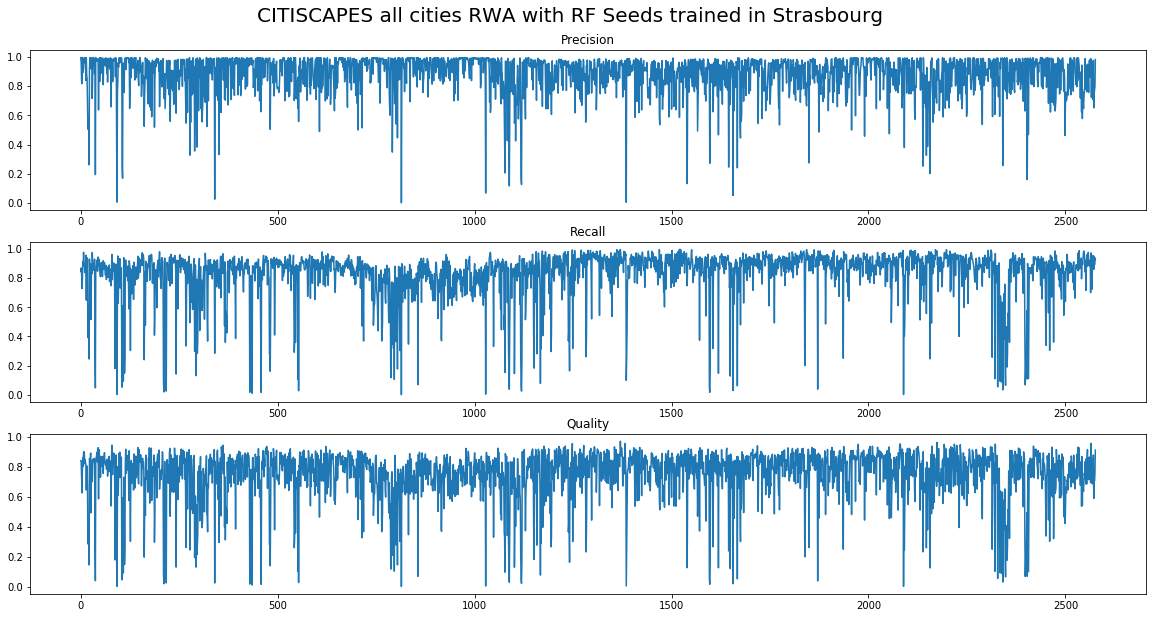

Results for all Cities RWA with RF Seeds trained in Strasbourg
Precision
Mean, Var, max, min
0.8837035248520501 0.01791315993453101 0.9976776343781024 0.0
Recall
0.8293658296628988 0.029802909707099257 0.9988866707616708 0.0
Quality
0.7480670517105141 0.029693465772378226 0.97392234463579 0.0


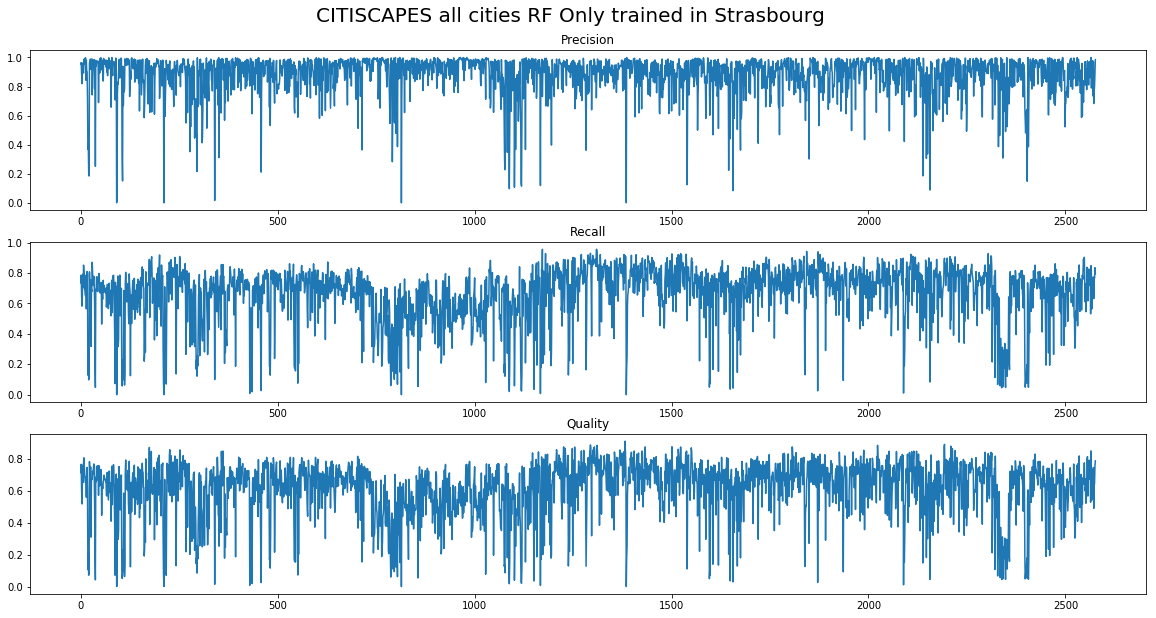

Results for all Cities RF Only trained in Strasbourg
Precision
Mean, Var, max, min
0.8795364638045867 0.019289423559508294 1.0 0.0
Recall
0.6631504160363096 0.03428868310820858 0.955340344816951 0.0
Quality
0.6102958108285278 0.03073476989719648 0.908221225710015 0.0


In [7]:
P=np.array(P)
C=np.array(C)
Q=np.array(Q)
    
mean_P=np.mean(P)
mean_C=np.mean(C)
mean_Q=np.mean(Q)

var_P=np.var(P)
var_C=np.var(C)
var_Q=np.var(Q)
    
max_C=np.max(C)
min_C=np.min(C)
    
max_P=np.max(P)
min_P=np.min(P)

max_Q=np.max(Q)
min_Q=np.min(Q)

plt.figure(figsize=(20,10))
plt.suptitle('CITISCAPES all cities RWA with RF Seeds trained in Strasbourg',y=0.94, fontsize=20)     
plt.subplot(311)
plt.plot(P)
plt.title("Precision")
plt.subplot(312)
plt.plot(C)
plt.title("Recall")
plt.subplot(313)
plt.plot(Q)
plt.title("Quality")
plt.show()

print("Results for all Cities RWA with RF Seeds trained in Strasbourg")
print("Precision")
print("Mean, Var, max, min")
print(mean_P,var_P,max_P,min_P)
print("Recall")
print(mean_C,var_C,max_C,min_C)
print("Quality")
print(mean_Q,var_Q,max_Q,min_Q)


P2=np.array(P2)
C2=np.array(C2)
Q2=np.array(Q2)
    
mean_P2=np.mean(P2)
mean_C2=np.mean(C2)
mean_Q2=np.mean(Q2)

var_P2=np.var(P2)
var_C2=np.var(C2)
var_Q2=np.var(Q2)
    
max_C2=np.max(C2)
min_C2=np.min(C2)
    
max_P2=np.max(P2)
min_P2=np.min(P2)

max_Q2=np.max(Q2)
min_Q2=np.min(Q2)


plt.figure(figsize=(20,10))
plt.suptitle('CITISCAPES all cities RF Only trained in Strasbourg',y=0.94, fontsize=20)     
plt.subplot(311)
plt.plot(P2)
plt.title("Precision")
plt.subplot(312)
plt.plot(C2)
plt.title("Recall")
plt.subplot(313)
plt.plot(Q2)
plt.title("Quality")
plt.show()

print("Results for all Cities RF Only trained in Strasbourg")
print("Precision")
print("Mean, Var, max, min")
print(mean_P2,var_P2,max_P2,min_P2)
print("Recall")
print(mean_C2,var_C2,max_C2,min_C2)
print("Quality")
print(mean_Q2,var_Q2,max_Q2,min_Q2)